In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import os
from tqdm.auto import tqdm
from nilearn import plotting
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
import sys



import monai
from monai.data import CSVSaver, ImageDataset, DistributedWeightedRandomSampler
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, NormalizeIntensity, Flip, ToTensor
from monai.utils import set_determinism
from monai.apps import CrossValidation


%matplotlib inline

/opt/conda/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [436]:
# GPU 할당 변경하기

GPU_NUM = 2 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(torch.cuda.current_device())

2


In [4]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.val_size = 0.2
args.test_size = 0.2
args.resize = (96,96,96)

# Data Prep 

## 데이터셋 만들기 

1) 이미지 파일을 갖고 온다.  
2) 다른 데이터에서 label과 target variable을 갖고 온다.  
3) 원하는 subject만큼 train, val, test 나눠준다.  
4) ImageDataset()으로 이미지 파일을 transform 해주고 데이터셋 선언을 해준다.  
5) partition 딕셔너리에 'train','val,'test' 키에 맞게 각 데이터셋을 넣어준다.  
6) 사용할 데이터셋 전체는 RAM에 올려놓고, batch size에 맞춰서 GPU RAM에 올리도록 구성할 것.  



96,96,96으로 resize 하기 

In [5]:
# getting image file names (subject ID + '.npy') as list 
base_dir = '/share/preprocessed_masked'
data_dir = '/share/preprocessed_masked'
os.chdir(data_dir)
image_files = glob.glob('*.npy')
image_files = sorted(image_files)
image_files = image_files[:400]


# subjects who have NaN values for sex already removed

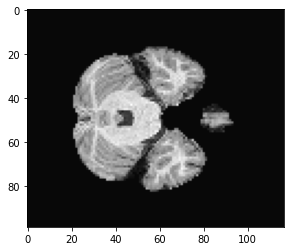

In [6]:
plt.imshow(np.load(image_files[0])[:,:,20],cmap=plt.cm.gray)

In [7]:
# getting subject ID and target variables 
target = 'sex'
#target = 'Attention.Deficit.Hyperactivity.Disorder.x'
subject_data = pd.read_csv('/share/data/ABCD_phenotype_total.csv')
subject_data = subject_data.loc[:,['subjectkey',target]]
subject_data = subject_data.sort_values(by='subjectkey')
subject_data = subject_data.dropna(axis = 0) 
subject_data = subject_data.reset_index(drop=True) # removing subject have NA values in sex
subject_data

subjectkey  sex
0      NDARINV003RTV85  2.0
1      NDARINV007W6H7B  1.0
2      NDARINV00BD7VDC  1.0
3      NDARINV00CY2MDM  1.0
4      NDARINV00HEV6HB  1.0
...                ...  ...
11526  NDARINVZZNX6W2P  1.0
11527  NDARINVZZPKBDAC  2.0
11528  NDARINVZZZ2ALR6  2.0
11529  NDARINVZZZNB0XC  2.0
11530  NDARINVZZZP87KR  2.0

[11531 rows x 2 columns]

In [8]:
# getting subject ID and target variables as sorted list 

imageFiles_labels = []
male = 0
female = 0

for subjectID in tqdm(image_files):
    subjectID = subjectID[:-4] #removing '.npy' for comparing
    #print(subjectID)
    for i in range(len(subject_data)):
        if subjectID == subject_data['subjectkey'][i]:
            if subject_data['sex'][i] == 1:
                imageFiles_labels.append((subjectID+'.npy',0))
                male +=1
            elif subject_data['sex'][i] == 2:
                imageFiles_labels.append((subjectID+'.npy',1))
                female +=1
            else:
                print('NaN value for {}'.format(subjectID))
                continue



In [9]:
def partition(imageFiles_labels,args):
    random.shuffle(imageFiles_labels)
    
    images = []
    labels = []
    for imageFile_label in imageFiles_labels:
        image, label = imageFile_label
        images.append(image)
        labels.append(label)
        
    
    
    resize = args.resize
    train_transform = Compose([AddChannel(),
                               Resize(resize),
                              ToTensor()])
    
    val_transform = Compose([AddChannel(),
                               Resize(resize),
                              ToTensor()])
    
    test_transform = Compose([AddChannel(),
                               Resize(resize),
                              ToTensor()])
    
    
    num_total = len(images)
    num_train = int(num_total*(1 - args.val_size - args.test_size))
    print(num_train)
    num_val = int(num_total*args.val_size)
    print(num_val)
    num_test = int(num_total*args.test_size)
    print(num_test)
    
    images_train = images[:num_train]
    labels_train = labels[:num_train]
    
    images_val = images[num_train:num_train+num_val]
    labels_val = labels[num_train:num_train+num_val]
    
    images_test = images[num_total-num_test:]
    labels_test = labels[num_total-num_test:]
    
    train_set = ImageDataset(image_files=images_train,labels=labels_train,transform=train_transform)
    val_set = ImageDataset(image_files=images_val,labels=labels_val,transform=val_transform)
    test_set = ImageDataset(image_files=images_test,labels=labels_test,transform=test_transform)
    
    partition = {}
    partition['train'] = train_set
    partition['val'] = val_set
    partition['test'] = test_set
    
    return partition 


In [10]:
partition = partition(imageFiles_labels,args)

235
78
78


# Model 

In [11]:
cfg = [8,'M',16,'M',32,64,'M',128,256,'M']

In [12]:
class CNN3D_1(nn.Module):
    def __init__(self,in_channels,out_dim):
        super(CNN3D_1,self).__init__()
        self.conv1 = nn.Conv3d(in_channels,8,kernel_size=3,stride=(1,1,1),padding=1) 
        self.conv2 = nn.Conv3d(8,16,kernel_size=3,stride=(1,1,1),padding=1)
        self.conv3 = nn.Conv3d(16,32,kernel_size=3,stride=(1,1,1),padding=1)
        self.conv4 = nn.Conv3d(32,64,kernel_size=3,stride=(1,1,1),padding=1)
        self.conv5 = nn.Conv3d(64,128,kernel_size=3,stride=(1,1,1),padding=1)
        self.conv6 = nn.Conv3d(128,256,kernel_size=3,stride=(1,1,1),padding=1)
        
        self.batchnorm1 = nn.BatchNorm3d(8)
        self.batchnorm2 = nn.BatchNorm3d(16)
        self.batchnorm3 = nn.BatchNorm3d(64)

        
        

        self.maxpool = nn.MaxPool3d(kernel_size=(2,2,2),stride=(2,2,2)) # 두가지 선택지, 1) padding = 0, kernel = 2; 2) padding = 1, kernel = 3 
        self.act = nn.ReLU()
        
        self.classifier = nn.Sequential(nn.Linear(6**3*256,19),
                                        nn.BatchNorm1d(19),
                                        nn.Sigmoid(),
                                        nn.Dropout(),
                                        nn.Linear(19,out_dim),
                                        nn.Softmax(dim=1))
        
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.batchnorm1(x)
        
        #print(x.size())
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.batchnorm2(x)
        #print(x.size())
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.batchnorm3(x)
        #print(x.size())
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpool(x)
        #print(x.size())
        x = x.view(x.size(0),-1)
        #print(x.size())
        x = self.classifier(x)
        
        return x 
        
        

## grad CAM image

기본 과정은 다음과 같다.  

- 네트워크를 선언한다.
- 이미 저장되어 있는 학습된 parameter를 앞서 선언한 네트워크에 얹어준다.  **네트워크 선언 -> 모델 로드의 과정 없이, 그냥 모델을 로드 해도 된다. 이럴 경우에는 net = torch.load(path)로 그냥 해주면 된다**
- input 이미지를 불러온다. 이때 네트워크에 바로 feed forward 할 수 있도록 dataloader를 통해서 불러온다.
- activation map을 계산하는 monai.visualize.GradCAM() 클래스를 선언한다. 이 클래스를 선언할 때에는 activation map 계산에 사용하고자 하는 모델 (즉, 앞서서 로딩한 학습된 모델)과 target으로 하는 layer (일반적으로는 가장 마지막 convolution layer)를 지정해주어야 한다.
- 앞서 선언한 monai.visualize.GradCAM() 클래스의 함수들을 통해서 activation map을 구해준다. 이때 input으로 들어가는 것은 앞서 dataloader로 불러왔던 이미지이다. 이때 이미지의 차원은 [batch_size, x, y, z]의 4차원이다.
- monai.visualize.GradCAM() 클래스의 함수들을 통해서 구한 activation map에는 원래 이미지의 사이즈인 (96,96,96), 즉 3차원이 아니라 차원이 추가된 형태이다. 그런데 다른 차원들은 사이즈가 1이기 때문에, squeeze를 통해서 지워주어야지 원래 사이즈인 (96,96,96)의 activation map을 얻을 수 있다.
- 이렇게 얻은 activation map과 원래의 이미지를 overlay 하면 된다. 이때 3차원 이미지이기 때문에 나머지 두 축은 그대로 놔둔채 하나의 축을 계속해서 바꿔가면서 2차원 이미지를 만들어 준다. 
- section 별로 (horizontal, coronal, sagittal) 이미지를 여러장 만들어 저장한 다음에, 이 이미지들을 불러와서 하나의 gif 파일로 만들어준다. 

In [13]:
'''네트워크를 선언한다.
   이미 저장되어 있는 학습된 parameter를 앞서 선언한 네트워크에 얹어준다.'''

net = CNN3D_1(in_channels=1,
              out_dim=2)

model_state, optimizer_state = torch.load("/share/simple_3DCNN_sex_classification_KoreaAIconference_epoch200-200.pt")
net.load_state_dict(model_state,strict=False)
        
net.cuda()

CNN3D_1(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv5): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batchnorm1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (act): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=55296, out_f

In [14]:
'''input 이미지를 불러온다. 
   이때 네트워크에 바로 feed forward 할 수 있도록 dataloader를 통해서 불러온다.'''

data_dir = '/share/preprocessed_masked'
os.chdir(data_dir)
testloader = torch.utils.data.DataLoader(partition['test'],
                                         batch_size=1,
                                         shuffle=True,
                                         num_workers=2)

# selcting male or female 
for i, data in enumerate(testloader,0):
    image, label = data 
    if label.item() == 0:
        break

In [15]:
label

tensor([0])

In [16]:
'''activation map을 계산하는 monai.visualize.GradCAM() 클래스를 선언한다. 
   이 클래스를 선언할 때에는 activation map 계산에 사용하고자 하는 모델 (즉, 앞서서 로딩한 학습된 모델)과 
   target으로 하는 layer (일반적으로는 가장 마지막 convolution layer)를 지정해주어야 한다.'''

cam = monai.visualize.GradCAM(nn_module=net, target_layers="conv6")

In [17]:
'''앞서 선언한 monai.visualize.GradCAM() 클래스의 함수들을 통해서 activation map을 구해준다. 
   이때 input으로 들어가는 것은 앞서 dataloader로 불러왔던 이미지이다. 
   이때 이미지의 차원은 [batch_size, x, y, z]의 4차원이다.
   monai.visualize.GradCAM() 클래스의 함수들을 통해서 구한 activation map에는 원래 이미지의 사이즈인 (96,96,96), 
   즉 3차원이 아니라 차원이 추가된 형태이다. 
   그런데 다른 차원들은 사이즈가 1이기 때문에, squeeze를 통해서 지워주어야지 원래 사이즈인 (96,96,96)의 activation map을 얻을 수 있다.
   그리고 이 이미지는 tensor이기 때문에, 플롯을 그리기 위해서는 numpy array로 바꿔주어야 한다.'''

result = cam(image.cuda())
result = result.squeeze()
result = result.cpu().numpy()

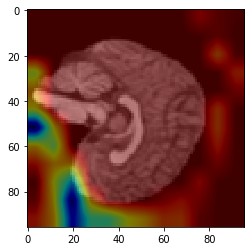

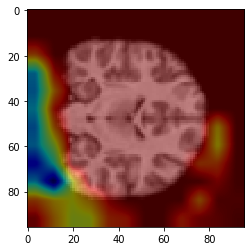

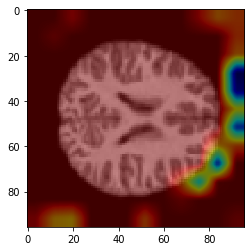

In [18]:
# mid-sagittal image 
plt.figure()
plt.imshow(image.squeeze().numpy()[48,:,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(result[48,:,:],interpolation='bilinear',cmap='jet',alpha=0.5)

# mid-scoronal image
plt.figure()
plt.imshow(image.squeeze().numpy()[:,48,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(result[:,48,:],interpolation='bilinear',cmap='jet',alpha=0.5)

# mid-horizontal image
plt.figure()
plt.imshow(image.squeeze().numpy()[:,:,48],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(result[:,:,48],interpolation='bilinear',cmap='jet',alpha=0.5)




## making gif image

horizontal, coronal, sagittal section respectively

BrainImage_horizontal = image.squeeze.numpy()[:,:,slice_location]  
BrainImage_coronal = image.squeeze.numpy()[:,slice_location,:]  
BrainImage_sagittal = image.squeeze.numpy()[slice_location,:,:]

### save image first

/tmp/ipykernel_25/4114040021.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


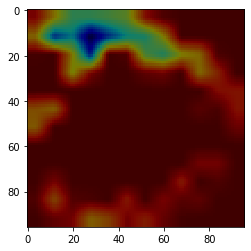

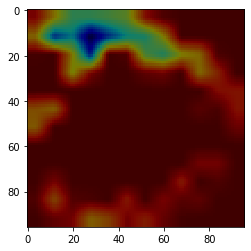

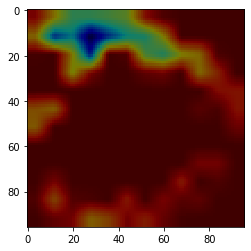

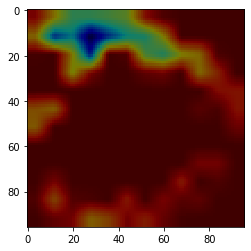

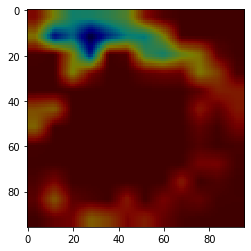

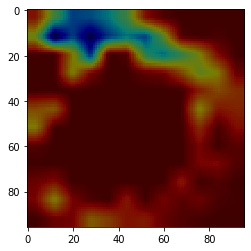

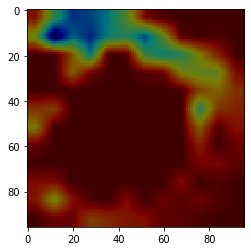

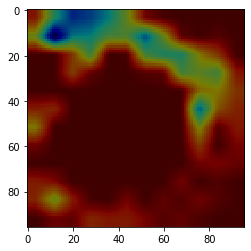

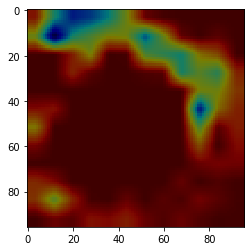

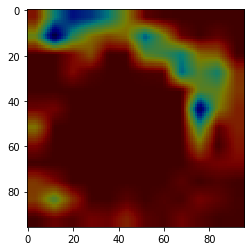

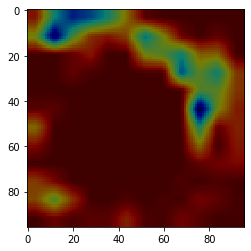

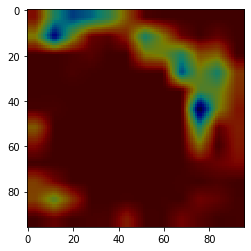

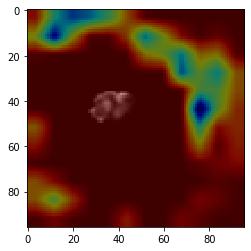

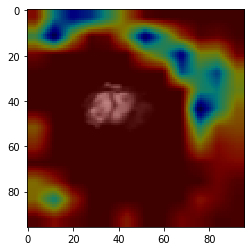

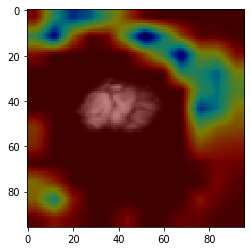

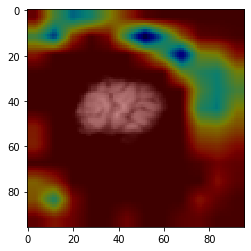

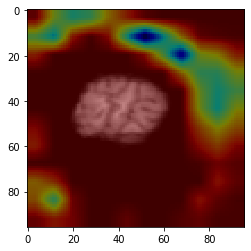

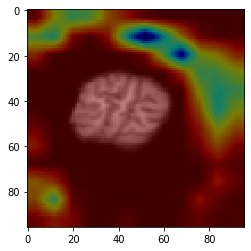

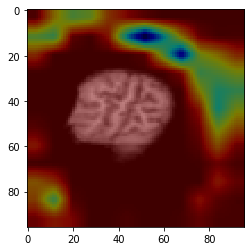

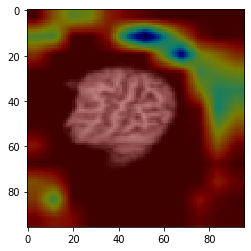

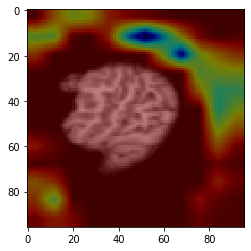

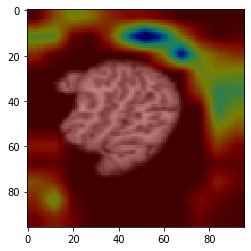

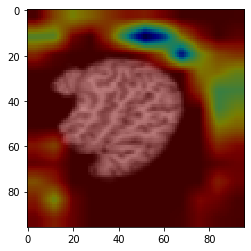

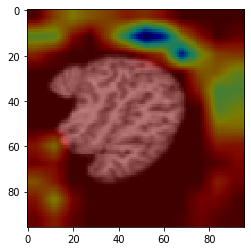

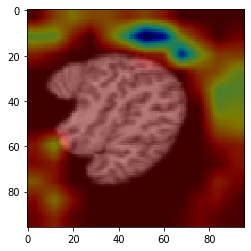

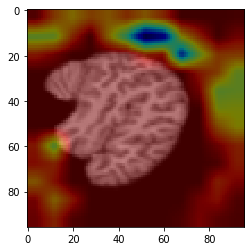

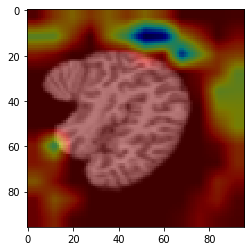

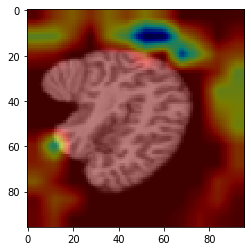

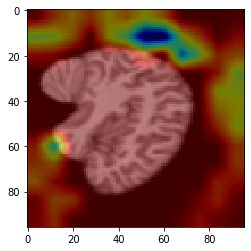

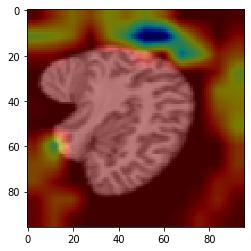

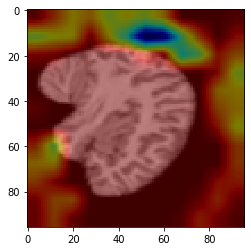

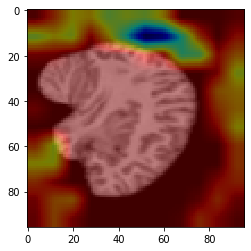

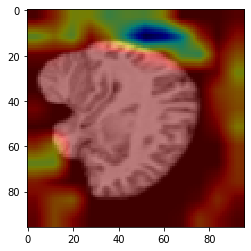

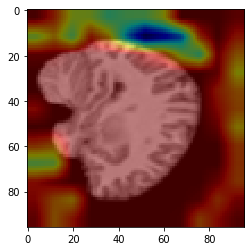

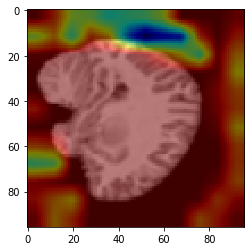

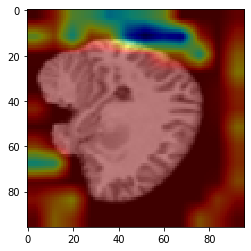

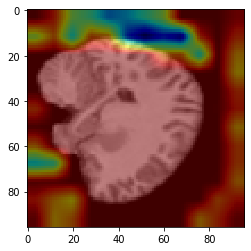

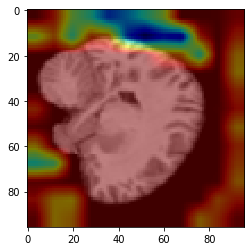

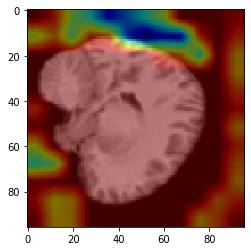

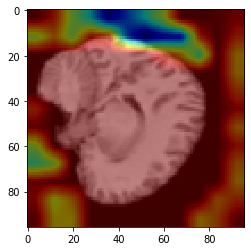

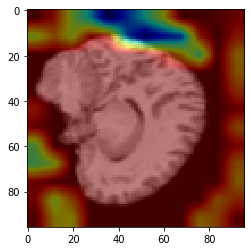

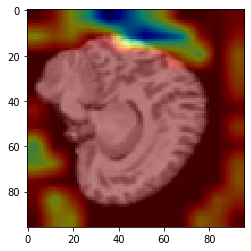

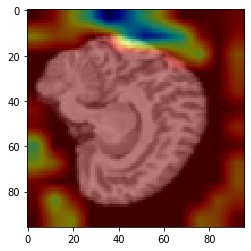

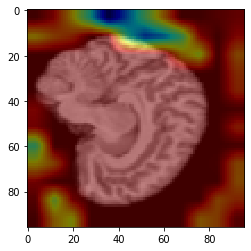

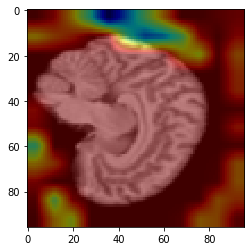

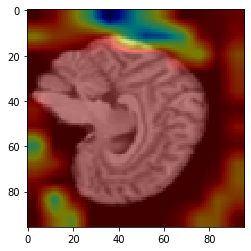

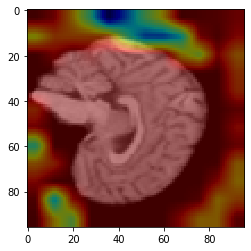

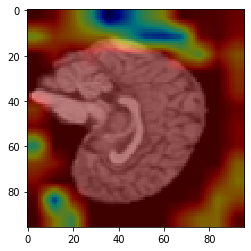

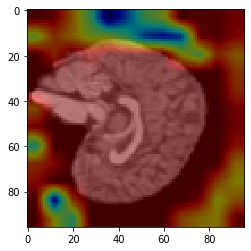

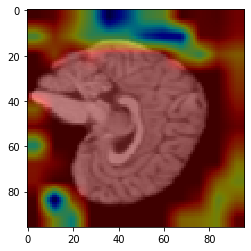

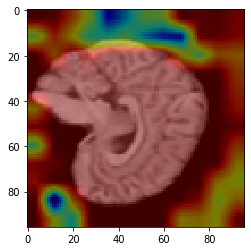

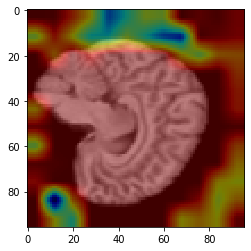

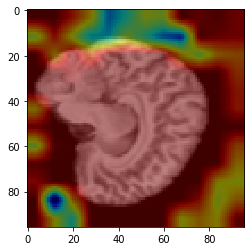

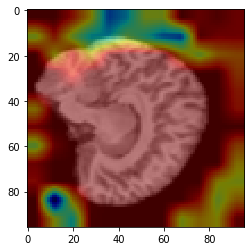

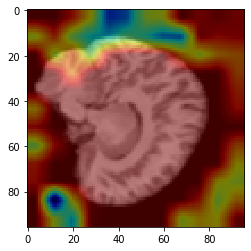

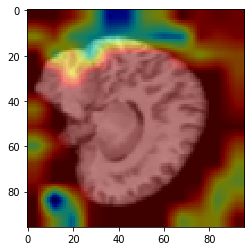

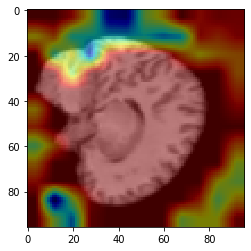

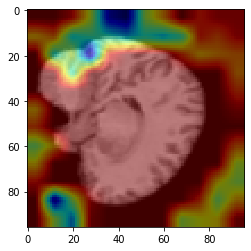

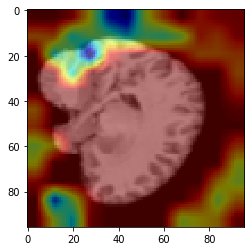

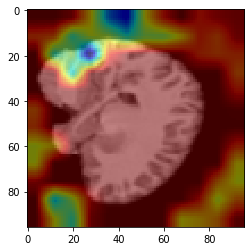

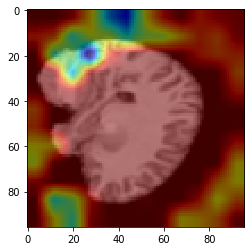

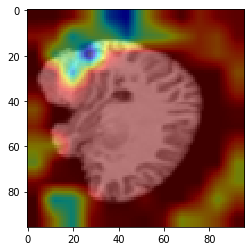

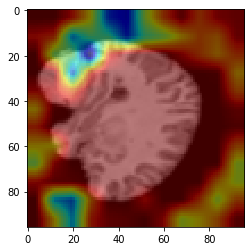

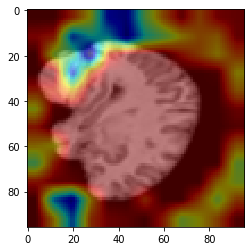

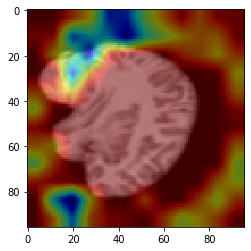

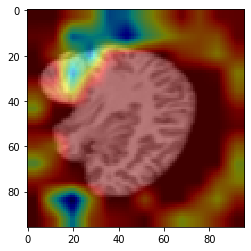

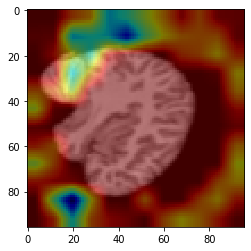

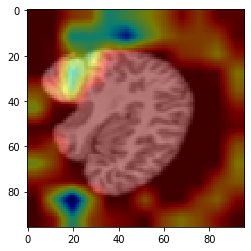

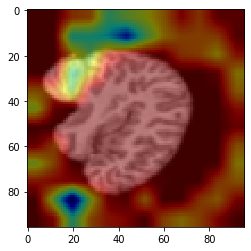

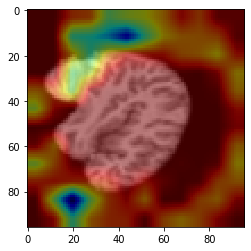

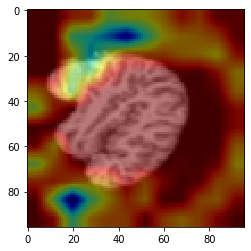

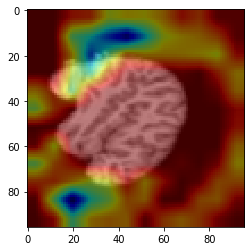

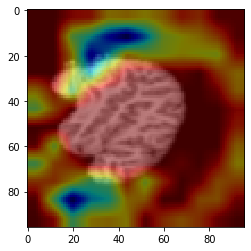

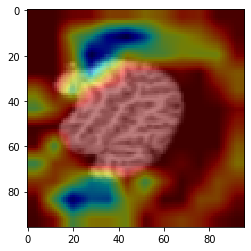

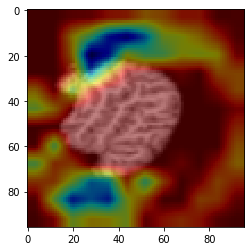

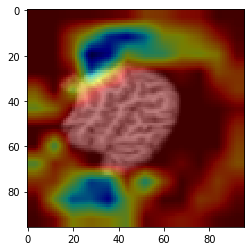

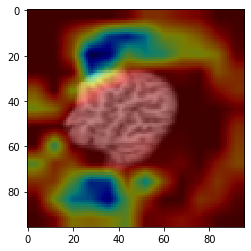

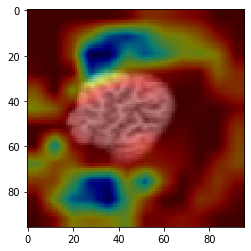

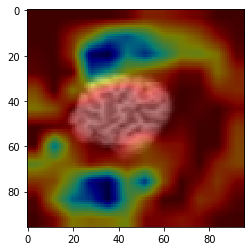

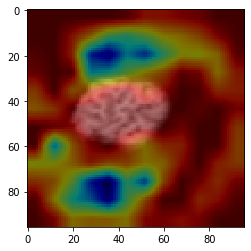

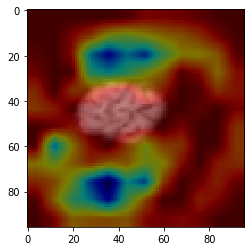

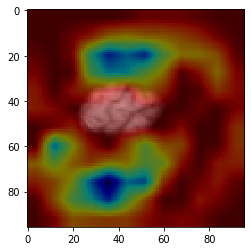

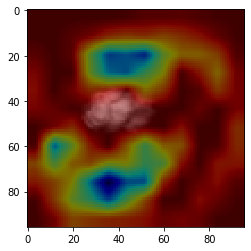

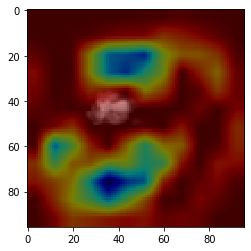

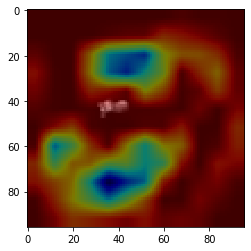

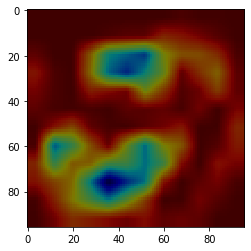

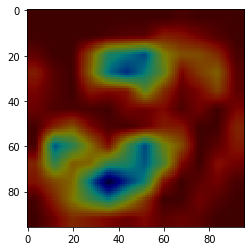

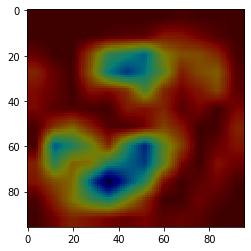

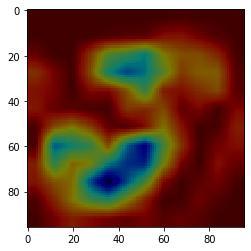

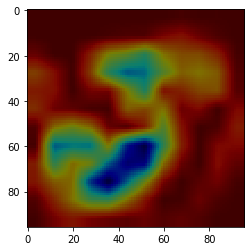

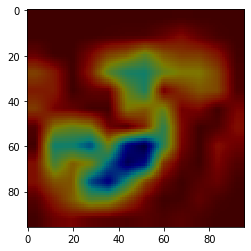

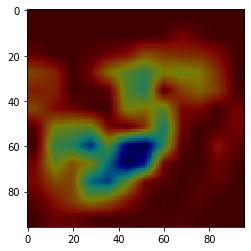

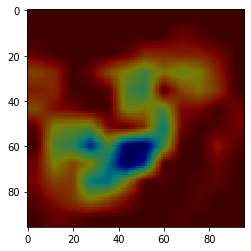

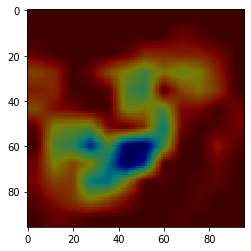

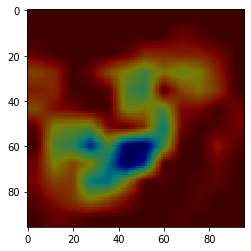

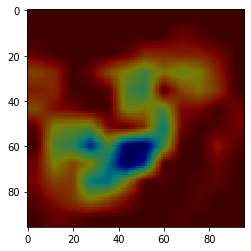

In [512]:
'''이렇게 얻은 activation map과 원래의 이미지를 overlay 하면 된다. 
   이때 3차원 이미지이기 때문에 나머지 두 축은 그대로 놔둔채 하나의 축을 계속해서 바꿔가면서 2차원 이미지를 만들어 준다.
   section 별로 (horizontal, coronal, sagittal) 이미지를 여러장 만들어 저장한 다음에, 이 이미지들을 불러와서 하나의 gif 파일로 만들어준다.'''


for i in tqdm(range(96)):
    plt.figure()
    plt.imshow(image.squeeze().numpy()[i,:,:],interpolation='nearest',cmap=plt.cm.gray)
    plt.imshow(result[i,:,:],interpolation='nearest',cmap='jet',alpha=0.5)
    
    plt.savefig('/share/XAI_male/gradCAM_image/sagittal_{}.png'.format(i), dpi=300)

### making gif

In [513]:
import imageio


os.chdir('/share/XAI_male/gradCAM_image/')
file_names = glob.glob("*.png")

images = []
for i in tqdm(range(96)):
    images.append(imageio.imread('sagittal_{}.png'.format(i)))
    
imageio.mimsave('/share/XAI_male/gradCAM_sagittal.gif', images, duration = 0.1)

# Occlusion Sensitivity

기본 과정은 다음과 같다.  

- 네트워크를 선언한다.
- 이미 저장되어 있는 학습된 parameter를 앞서 선언한 네트워크에 얹어준다.
- input 이미지를 불러온다. 이때 네트워크에 바로 feed forward 할 수 있도록 dataloader를 통해서 불러온다.
- occlusion map을 계산하는 monai.visualize.OcclusionSensitivity() 클래스를 선언한다. 이 클래스를 선언할 때에는 activation map 계산에 사용하고자 하는 모델 (즉, 앞서서 로딩한 학습된 모델)과 batch size, mask size, stride를 지정해주어야 한다.
- 앞서 선언한 monai.visualize.OcclusionSensitivity() 클래스의 함수들을 통해서 occlusion map을 구해준다. 이때 input으로 들어가는 것은 앞서 dataloader로 불러왔던 이미지이다. 이때 이미지의 차원은 [batch_size, x, y, z]의 4차원이다. b_box (boundary box)를 지정해주지 않으면, 원래의 input size와 똑같은 사이즈의 occlusion map이 나온다.
- monai.visualize.OcclusionSensitivity() 클래스의 함수들을 통해서 구한 occlusion map에는 원래 이미지의 사이즈인 (96,96,96), 즉 3차원이 아니라 차원이 추가된 형태이다. 여기에 ground truth label에 대한 occlusion map을 얻는 과정과 함께 squeeze를 통해서 지워주는 고정을 거쳐야지 원래 사이즈인 (96,96,96)의 occlusion map을 얻을 수 있다. ground truth label에 대한 occlusion map을 얻는 과정은 <occ_map = occ_map[..., label]>
- 이렇게 얻은 occlusion map과 원래의 이미지를 overlay 하면 된다. 이때 3차원 이미지이기 때문에 나머지 두 축은 그대로 놔둔채 하나의 축을 계속해서 바꿔가면서 2차원 이미지를 만들어 준다. 
- section 별로 (horizontal, coronal, sagittal) 이미지를 여러장 만들어 저장한 다음에, 이 이미지들을 불러와서 하나의 gif 파일로 만들어준다. 

- **유의할 점은 network랑 이미지 데이터를 cuda에 올려서 gpu 연산을 시켜야지만 계산 시간이 적게 걸린다는 것이다**

In [19]:
'''네트워크를 선언한다.
   이미 저장되어 있는 학습된 parameter를 앞서 선언한 네트워크에 얹어준다.'''

net = CNN3D_1(in_channels=1,
              out_dim=2)

model_state, optimizer_state = torch.load("/share/simple_3DCNN_sex_classification_KoreaAIconference_epoch200-200.pt")
net.load_state_dict(model_state,strict=False)

net.cuda()
        


CNN3D_1(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv5): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (batchnorm1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (act): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=55296, out_f

In [20]:
'''input 이미지를 불러온다. 
   이때 네트워크에 바로 feed forward 할 수 있도록 dataloader를 통해서 불러온다.'''


data_dir = '/share/preprocessed_masked'
os.chdir(data_dir)

testloader = torch.utils.data.DataLoader(partition['test'],
                                         batch_size=1,
                                         shuffle=True,
                                         num_workers=2)


for i, data in enumerate(testloader,0):
    image, label = data 
    
    # select male or female
    if label.item() == 0:
        break

        
image = image.cuda()
label = label.cuda()    
output = net(image)
_,predicted = torch.max(output.data,1)

In [21]:
label

tensor([0])

In [22]:
'''occlusion map을 계산하는 monai.visualize.OcclusionSensitivity() 클래스를 선언한다. 
   이 클래스를 선언할 때에는 activation map 계산에 사용하고자 하는 모델 (즉, 앞서서 로딩한 학습된 모델)과 
   batch size, mask size, stride를 지정해주어야 한다.
   monai.visualize.OcclusionSensitivity() 클래스의 함수들을 통해서 구한 occlusion map에는 원래 이미지의 사이즈인 (96,96,96), 즉 3차원이 아니라 차원이 추가된 형태이다. 
   여기에 ground truth label에 대한 occlusion map을 얻는 과정과 함께,
   squeeze를 통해서 지워주는 고정을 거쳐야지 원래 사이즈인 (96,96,96)의 occlusion map을 얻을 수 있다. 
   ground truth label에 대한 occlusion map을 얻는 과정은 <occ_map = occ_map[..., label]>
   
   유의할 점은 network랑 이미지 데이터를 cuda에 올려서 gpu 연산을 시켜야지만 계산 시간이 적게 걸린다는 것이다.
   따라서 계산이 끝난 다음에 occ_map과 이미지를 cpu로 다시 도렬 보내야 한다.
'''

# hyper parameter
size_stride = 4 
size_mask = 12 

# assign class
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=net, mask_size = size_mask, n_batch=1, stride=size_stride)
occ_map, _ = occ_sens(image)
occ_map = occ_map[..., predicted.item()] # ground truth label에 대한 occlusion map을 얻는 과정

occ_map = occ_map.cpu()
image = image.cpu()

    

Computing occlusion sensitivity: 100%|███| 13824/13824 [01:13<00:00, 189.02it/s]


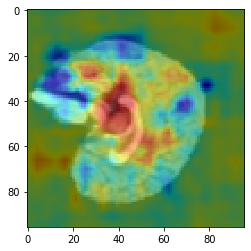

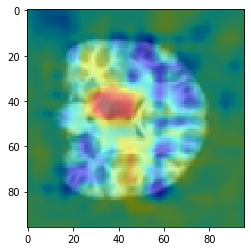

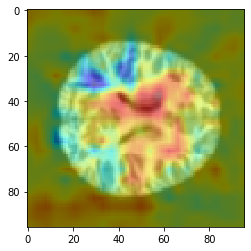

In [23]:
# mid-sagittal image 
plt.figure()
plt.imshow(image.squeeze().numpy()[48,:,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(occ_map.squeeze()[48,:,:],interpolation='nearest',cmap='jet',alpha=0.5)

# mid-scoronal image
plt.figure()
plt.imshow(image.squeeze().numpy()[:,48,:],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(occ_map.numpy().squeeze()[:,48,:],interpolation='nearest',cmap='jet',alpha=0.5)

# mid-horizontal image
plt.figure()
plt.imshow(image.squeeze().numpy()[:,:,48],interpolation='nearest',cmap=plt.cm.gray)
plt.imshow(occ_map.numpy().squeeze()[:,:,48],interpolation='nearest',cmap='jet',alpha=0.5)

## making gif image

- **BrainImage_horizontal**    
original image coordinate = image.squeeze.numpy()[:,:,slice_location]  

  
- **BrainImage_coronal**  
original image coordinate = image.squeeze.numpy()[:,slice_location,:]  

  
- **BrainImage_sagittal**  
original image coordinate = image.squeeze.numpy()[slice_location,:,:]  


### save image first

/tmp/ipykernel_25/547979289.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


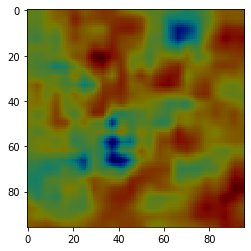

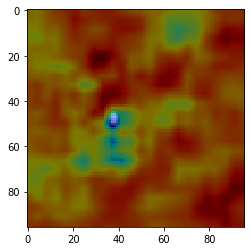

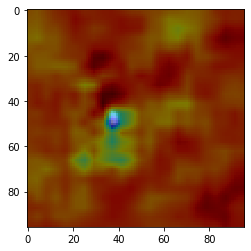

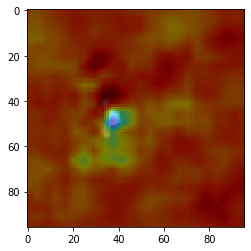

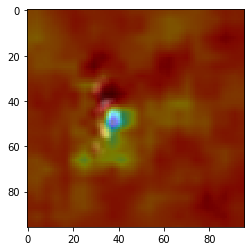

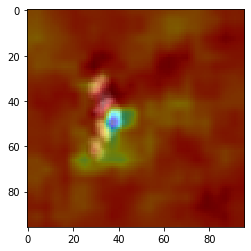

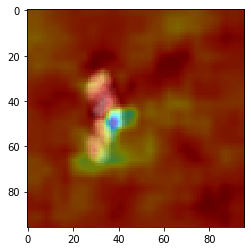

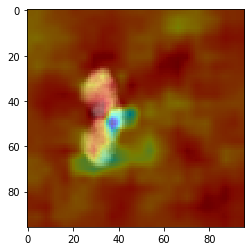

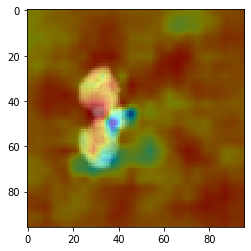

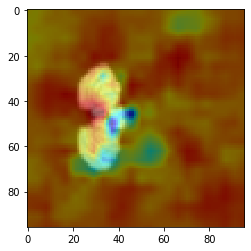

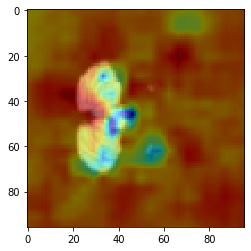

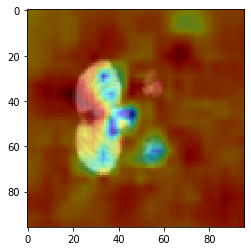

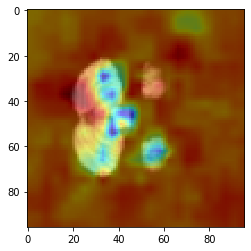

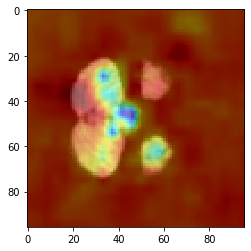

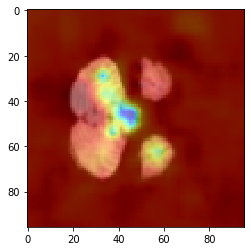

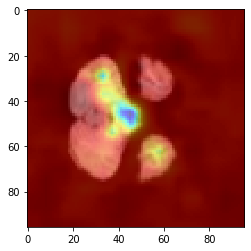

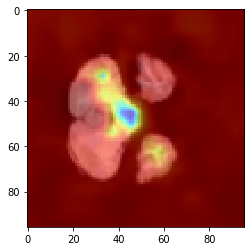

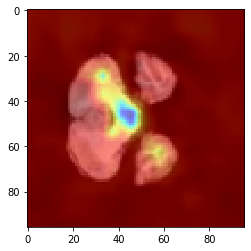

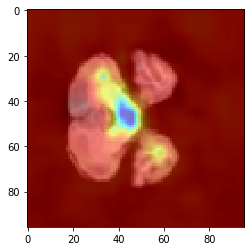

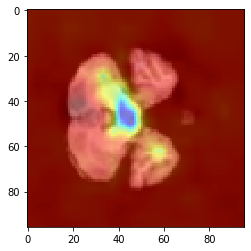

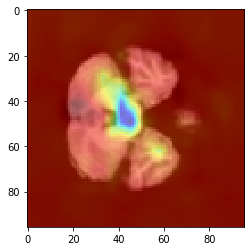

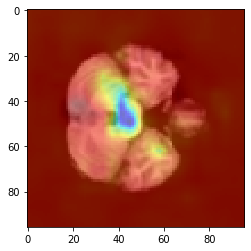

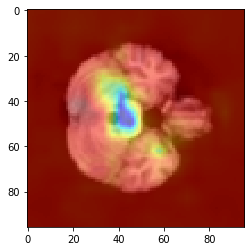

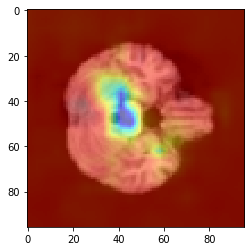

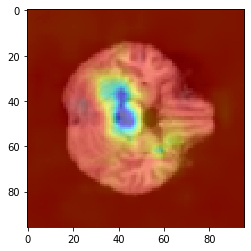

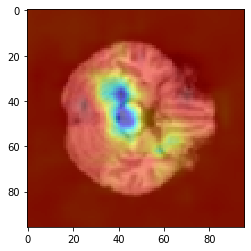

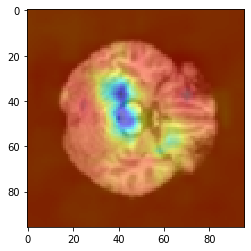

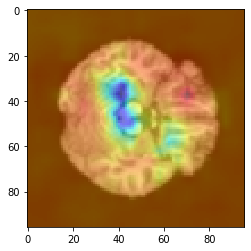

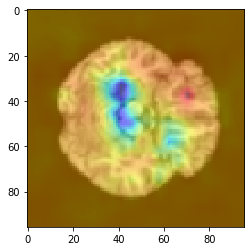

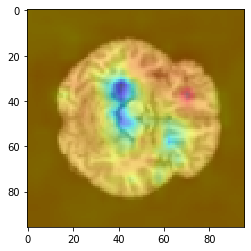

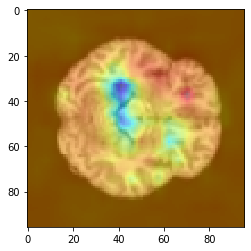

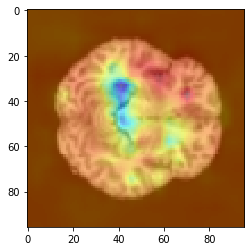

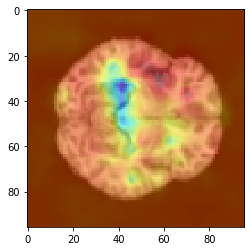

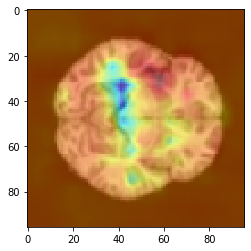

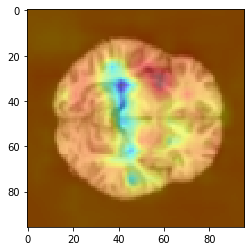

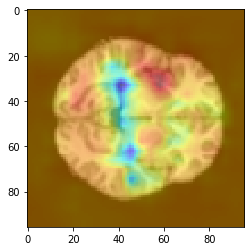

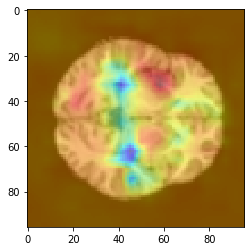

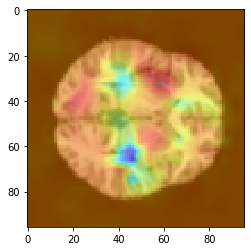

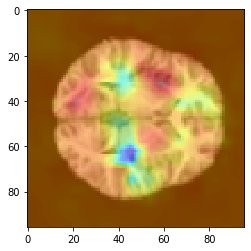

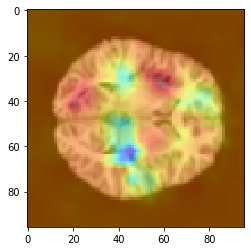

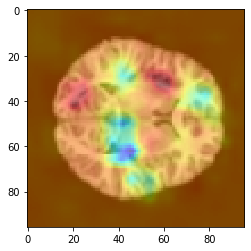

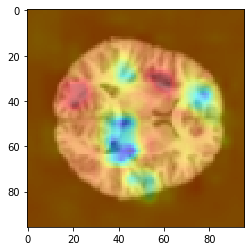

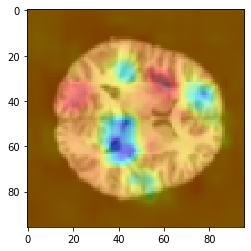

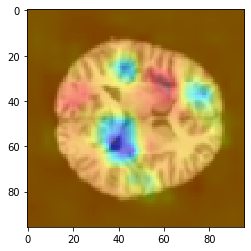

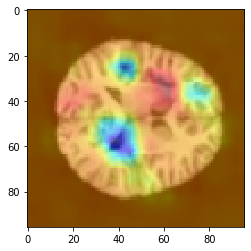

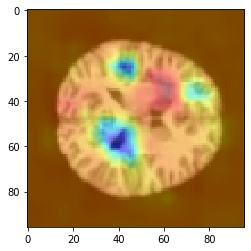

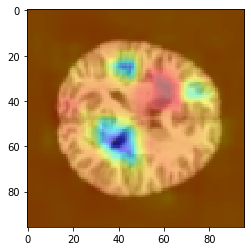

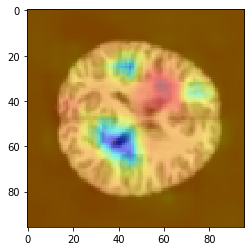

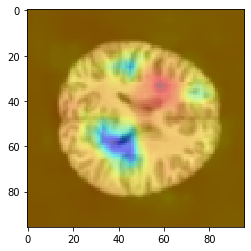

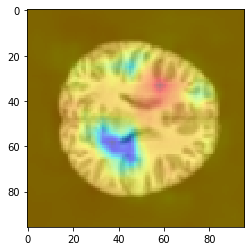

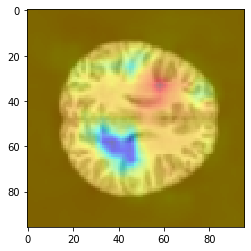

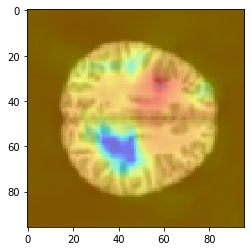

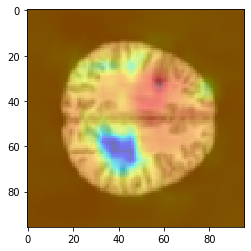

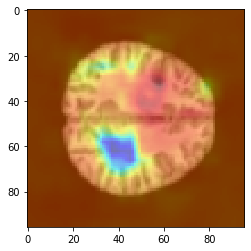

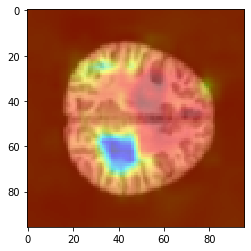

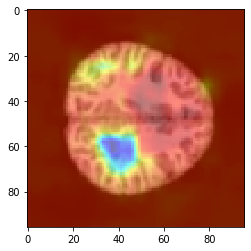

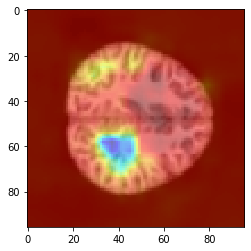

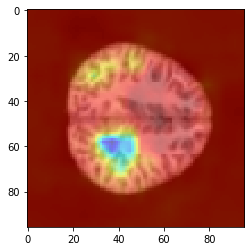

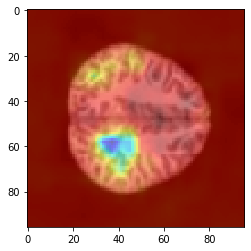

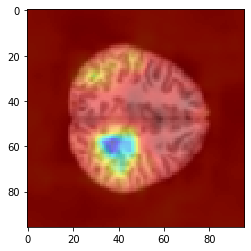

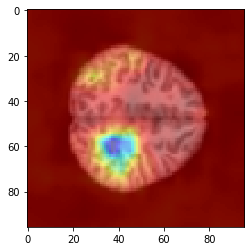

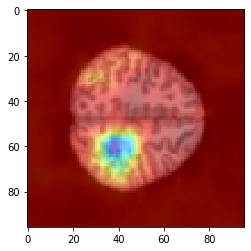

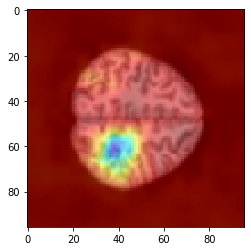

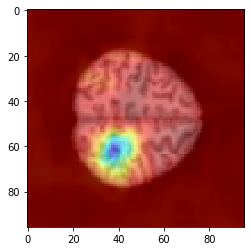

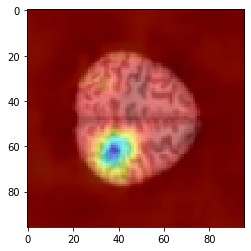

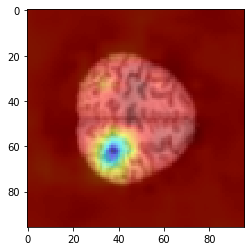

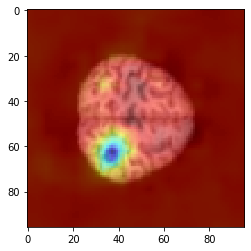

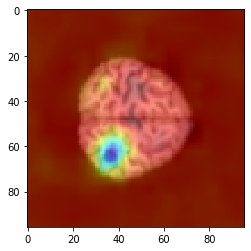

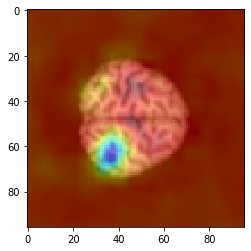

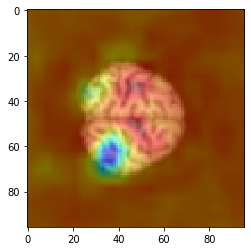

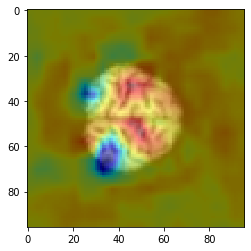

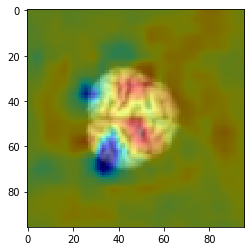

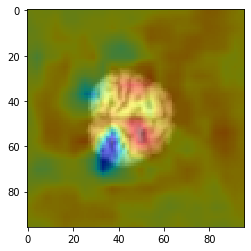

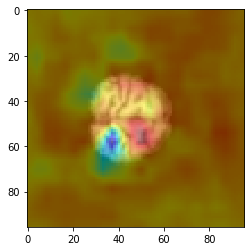

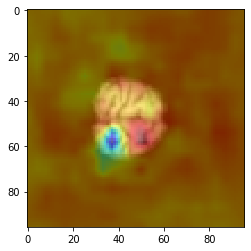

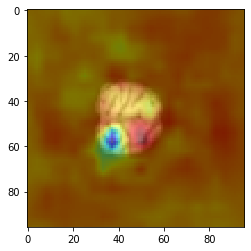

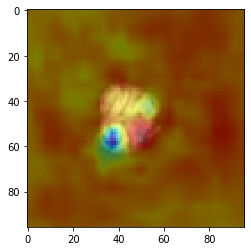

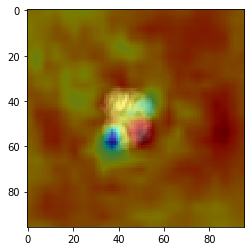

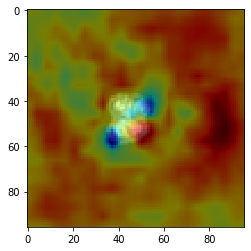

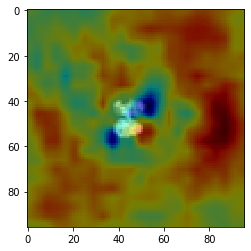

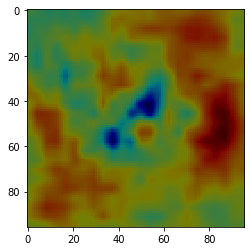

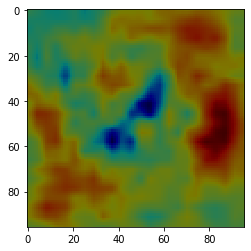

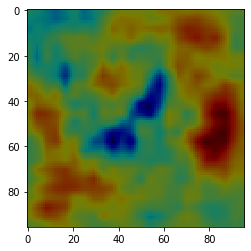

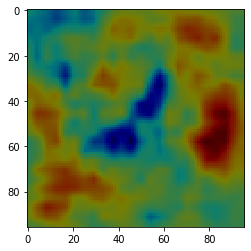

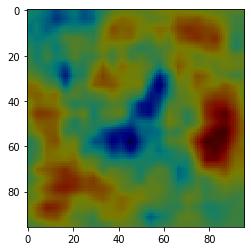

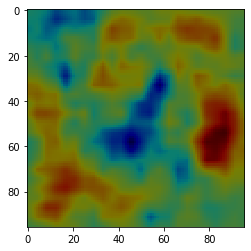

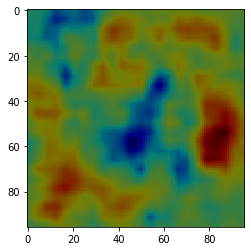

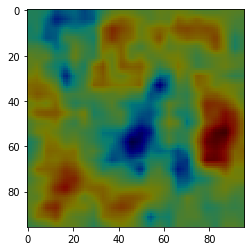

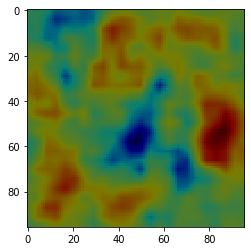

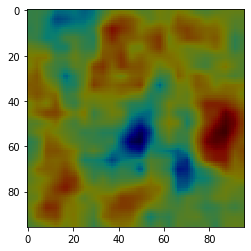

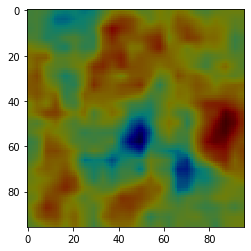

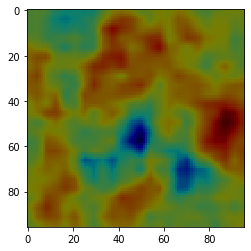

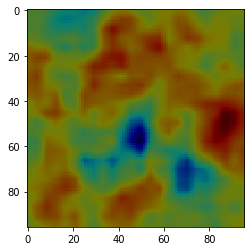

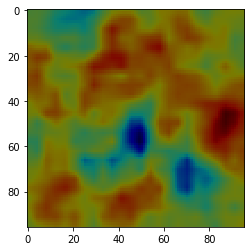

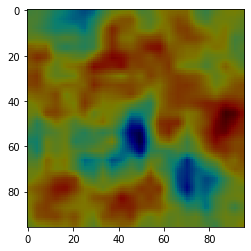

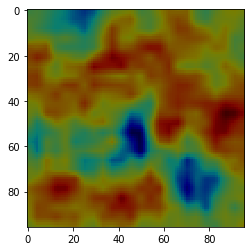

In [521]:
'''이렇게 얻은 occlusion map과 원래의 이미지를 overlay 하면 된다. 
   이때 3차원 이미지이기 때문에 나머지 두 축은 그대로 놔둔채 하나의 축을 계속해서 바꿔가면서 2차원 이미지를 만들어 준다.
   section 별로 (horizontal, coronal, sagittal) 이미지를 여러장 만들어 저장한 다음에, 이 이미지들을 불러와서 하나의 gif 파일로 만들어준다.
'''
for i in tqdm(range(96)):
    plt.figure()
    plt.imshow(image.squeeze().numpy()[:,:,i],interpolation='nearest',cmap=plt.cm.gray)
    plt.imshow(occ_map.cpu().numpy().squeeze()[:,:,i],interpolation='nearest',cmap='jet',alpha=0.5)
    
    plt.savefig('/share/XAI_male/occ_sense_image/horizontal_{}.png'.format(i), dpi=300)

### making gif

In [513]:
import imageio

os.chdir('/share/XAI_male/occ_sense_image/')
file_names = glob.glob("*.png")

images = []
for i in tqdm(range(96)):
    images.append(imageio.imread('horizontal_{}.png'.format(i)))
    
imageio.mimsave('/share/XAI_male/occ_sense_horizontal.gif', images, duration = 0.1)